# 01. Validating shoreline

*Written by Men Vuthy, 2023*

---


In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString, MultiPoint
from shapely import geometry, ops
from shapely.affinity import rotate
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import proplot as pplt
from scipy.stats import gaussian_kde

In [2]:
# Function to create points along geometry at a specific distance
def Create_points(line_geo, distance):
    distances = np.arange(0, line_geo.length, distance)
    points = [line_geo.interpolate(dist) for dist in distances] + [line_geo.boundary]
    return points

# Function to extrapolate line forward
def ExtrapolateOut(p1,p2,distance):
    'Creates a line extrapoled in p1->p2 direction'
    EXTRAPOL_RATIO = distance
    a = p1
    b = (p1[0]+EXTRAPOL_RATIO*(p2[0]-p1[0]), p1[1]+EXTRAPOL_RATIO*(p2[1]-p1[1]) )
    return LineString([a,b])

# Function to extrapolate line backward
def ExtrapolateIn(p1,p2,distance):
    'Creates a line extrapoled in p1->p2 direction'
    EXTRAPOL_RATIO = -distance
    a = p1
    b = (p1[0]+EXTRAPOL_RATIO*(p2[0]-p1[0]), p1[1]+EXTRAPOL_RATIO*(p2[1]-p1[1]) )
    return LineString([a,b])

  
def from_point_to_line(shape):
  # Create linestring
  line = LineString(shape['geometry'].dropna().reset_index(drop=True))
  
  # Create new geodataframe
  new_shape = gpd.GeoDataFrame({'geometry':[line]}, crs=shape.crs)
  new_shape = new_shape.dropna().reset_index(drop=True)
  new_shape['id'] = new_shape.index

  return new_shape

In [3]:
# Read data
manual_shoreline = gpd.read_file('Manual shoreline/Fonadhoo_manual_shoreline_east.geojson')
sentinel_shoreline = gpd.read_file('Sentinel shoreline/Sentinel_shoreline_20210801_1031_east.geojson')
landsat_shoreline = gpd.read_file('Landsat shoreline/Landsat_shoreline_20210801_1031_east.geojson')
reference_line = gpd.read_file('Reference line/Fonadhoo_reference_line.geojson')

# Create a list of all shoreline
all_shoreline = [manual_shoreline, sentinel_shoreline, landsat_shoreline]

# Create transect line

In [4]:
# Create folder
if not os.path.exists('output'):
  os.makedirs('output')

# Create uniform point along reference line
points_along_ref_line = Create_points(reference_line['geometry'][0], 10)
points_ref_line = gpd.GeoDataFrame({'geometry':points_along_ref_line}, crs=reference_line.crs)
points_ref_line = points_ref_line.dropna().reset_index(drop=True)
points_ref_line['id'] = points_ref_line.index

# Create transect lines at every 10m point
line_list, line_in, line_out = [], [], []
for i in range(len(points_along_ref_line)-2):
  LS = LineString([points_along_ref_line[i].coords[0], points_along_ref_line[i+1].coords[0]])
  rotate_line = rotate(LS, 90, origin=points_along_ref_line[i].coords[0])
  Line_in = ExtrapolateIn(*rotate_line.coords, 30)
  Line_out = ExtrapolateOut(*rotate_line.coords, 30)
  Long_line = MultiLineString([Line_in, Line_out])
  line_list.append(Long_line)
  line_in.append(Line_in)
  line_out.append(Line_out)

# Create transect geodataframe
transect_line = gpd.GeoDataFrame({'geometry':line_list}, crs=reference_line.crs)
transect_line = transect_line.dropna().reset_index(drop=True)
transect_line['id'] = transect_line.index
# outfp = 'output/transect_line.json'
# transect_line.to_file(outfp, driver='GeoJSON')

### Calculate transect distance and export to GeoJSON

In [5]:
# Create folder
if not os.path.exists('output/shoreline'):
  os.makedirs('output/shoreline')
if not os.path.exists('output/transect_point'):
  os.makedirs('output/transect_point')

intersect_data, distance_data = [], []
for shoreline in all_shoreline:
    # Generate intersection points between transect line
    intersect_, distance_ = [], []
    for i in range(len(line_list)):
        try:
            intersection = line_list[i].intersection(shoreline['geometry'].unary_union)
            if type(intersection) == LineString:
                intersect_.append(0)
                distance_.append(0)
            if type(intersection)==Point:
                distance = LineString([line_list[i].centroid, intersection]).length
                intersect_.append(intersection)
                distance_.append(distance)
            if type(intersection)==MultiPoint:
                intersect_point_list = [point for point in intersection.geoms]
                distance = [LineString([line_list[i].centroid, intersection.geoms[j]]).length for j in range(len(intersection.geoms))]
                intersect_point = intersect_point_list[distance.index(min(distance))]
                intersect_.append(intersect_point)
                distance_.append(min(distance))

        except:
            pass
    
    intersect_data.append(intersect_)
    distance_data.append(distance_)

# Intersection
df_intersect = pd.DataFrame(intersect_data).T
df_intersect = df_intersect.loc[(df_intersect!=0).all(axis=1)]

# Distance
df_distance = pd.DataFrame(distance_data).T
df_distance = df_distance.loc[(df_distance!=0).all(axis=1)]

# Create a list of all shoreline
name_points = ['manual_points', 'sentinel_points', 'landsat_points']

# for i in range(len(name_points)):
#     # Create new geodataframe
#     geo_data = gpd.GeoDataFrame({'geometry':df_intersect[i]}, crs=manual_shoreline.crs)
#     geo_data = geo_data.dropna().reset_index(drop=True)
#     geo_data['id'] = geo_data.index
#     geo_data['distance'] = df_distance[i]
#     outfp = 'output/transect_point/'+name_points[i]+'.json'
#     geo_data.to_file(outfp, driver='GeoJSON')

# # Create a list of all shoreline
# name_lines = ['manual_shoreline', 'sentinel_shoreline', 'landsat_shoreline']

# for i in range(len(name_lines)):
#     # Create new geodataframe
#     geo_data = gpd.GeoDataFrame({'geometry':[LineString(df_intersect[i])]}, crs=manual_shoreline.crs)
#     geo_data = geo_data.dropna().reset_index(drop=True)
#     geo_data['id'] = geo_data.index
#     geo_data['distance'] = df_distance[i]
#     outfp = 'output/shoreline/'+name_lines[i]+'.json'
#     geo_data.to_file(outfp, driver='GeoJSON')

### Calculate Regression and Goodness of Fit

In [6]:
# Create new summary dataframe
data_distance = pd.DataFrame({'manual': df_distance[0], 'sentinel': df_distance[1], 'landsat': df_distance[2]})

#define variable
x = data_distance['manual']
y = data_distance['sentinel']
z = data_distance['landsat']

print('- Goodness of fit: Manual Vs Sentinel')

# Calculate R-squared
print("     R squared: %.3f" % r2_score(x, y))

#fit MAE
print("     Mean Absolute Error: %.2f" % mean_absolute_error(x, y))

#fit RMSE
print("     Root Mean Squared Error: %.2f" % mean_squared_error(x, y, squared=False))

#fit MSE
print("     Mean Squared Error: %.2f" % mean_squared_error(x, y, squared=True))

print('- Goodness of fit: Manual Vs Landsat')
# Calculate R-squared
print("     R squared: %.3f" % r2_score(x, z))

#fit MAE
print("     Mean Absolute Error: %.2f" % mean_absolute_error(x, z))

#fit RMSE
print("     Root Mean Squared Error: %.2f" % mean_squared_error(x, z, squared=False))

#fit MSE
print("     Mean Squared Error: %.2f" % mean_squared_error(x, z, squared=True))

- Goodness of fit: Manual Vs Sentinel
     R squared: 0.936
     Mean Absolute Error: 2.34
     Root Mean Squared Error: 3.04
     Mean Squared Error: 9.21
- Goodness of fit: Manual Vs Landsat
     R squared: 0.769
     Mean Absolute Error: 4.44
     Root Mean Squared Error: 5.76
     Mean Squared Error: 33.21


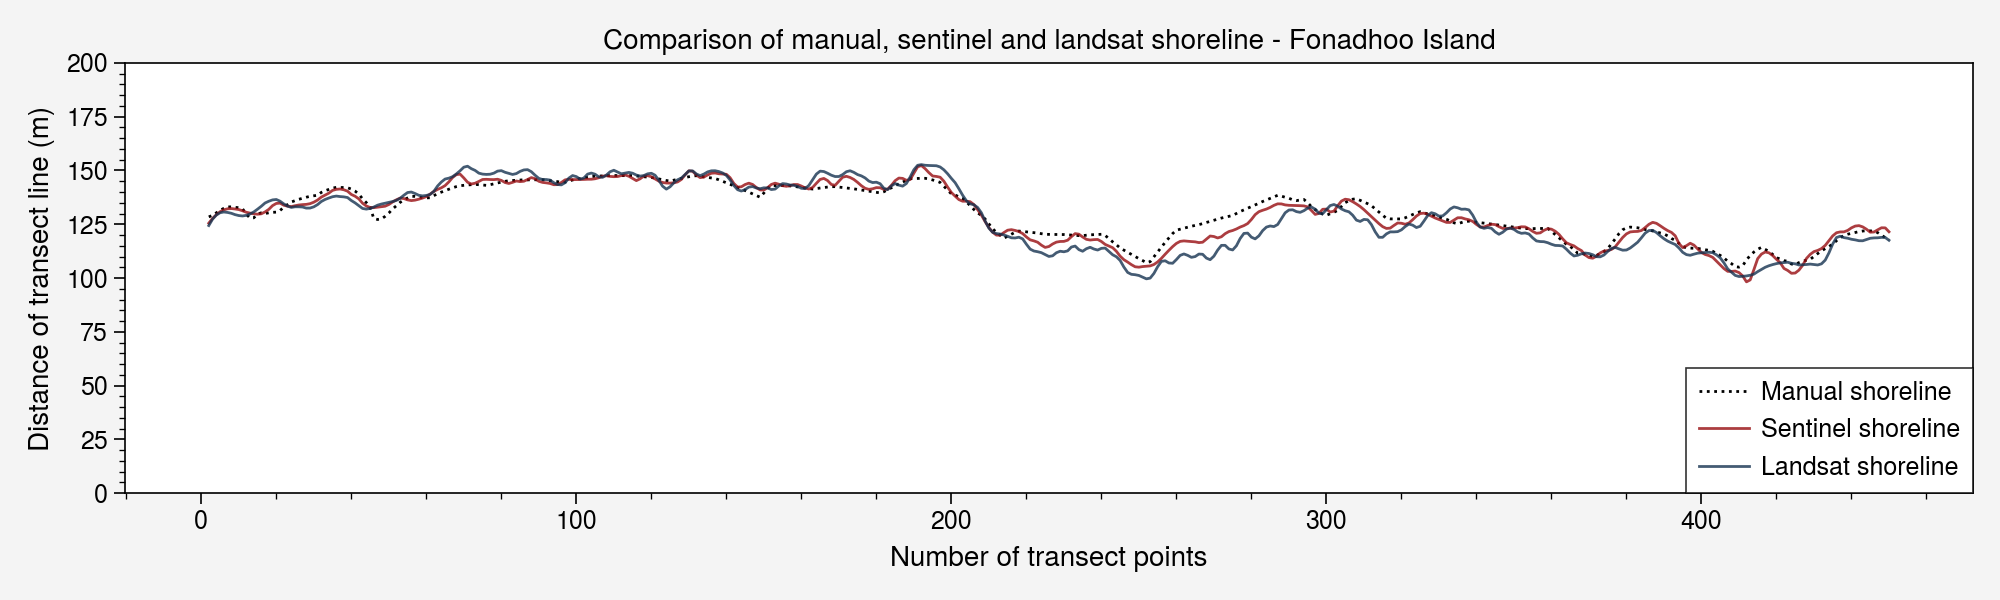

In [7]:
if not os.path.exists('output/graph'):
  os.makedirs('output/graph')

# Plotting regression
fig, (ax1) = plt.subplots(1, 1, figsize=(10,3))


ax1.plot(x, color="black", ls=':', lw=1, alpha=1, label='Manual shoreline')
ax1.plot(y, color="#970C10", ls='-',lw=1, alpha=0.8, label='Sentinel shoreline')
ax1.plot(z, color="#153250", ls='-',lw=1, alpha=0.8, label='Landsat shoreline')
ax1.set_ylim(0, 200)
ax1.set_title('Comparison of manual, sentinel and landsat shoreline - Fonadhoo Island', fontsize=10)
ax1.set_ylabel('Distance of transect line (m)', fontsize=10)
ax1.set_xlabel('Number of transect points', fontsize=10)
ax1.legend(loc='lower right')
ax1.grid(False)

plt.tight_layout()
plt.savefig('output/graph/3_shoreline_comparison.png', dpi=300)
plt.show()

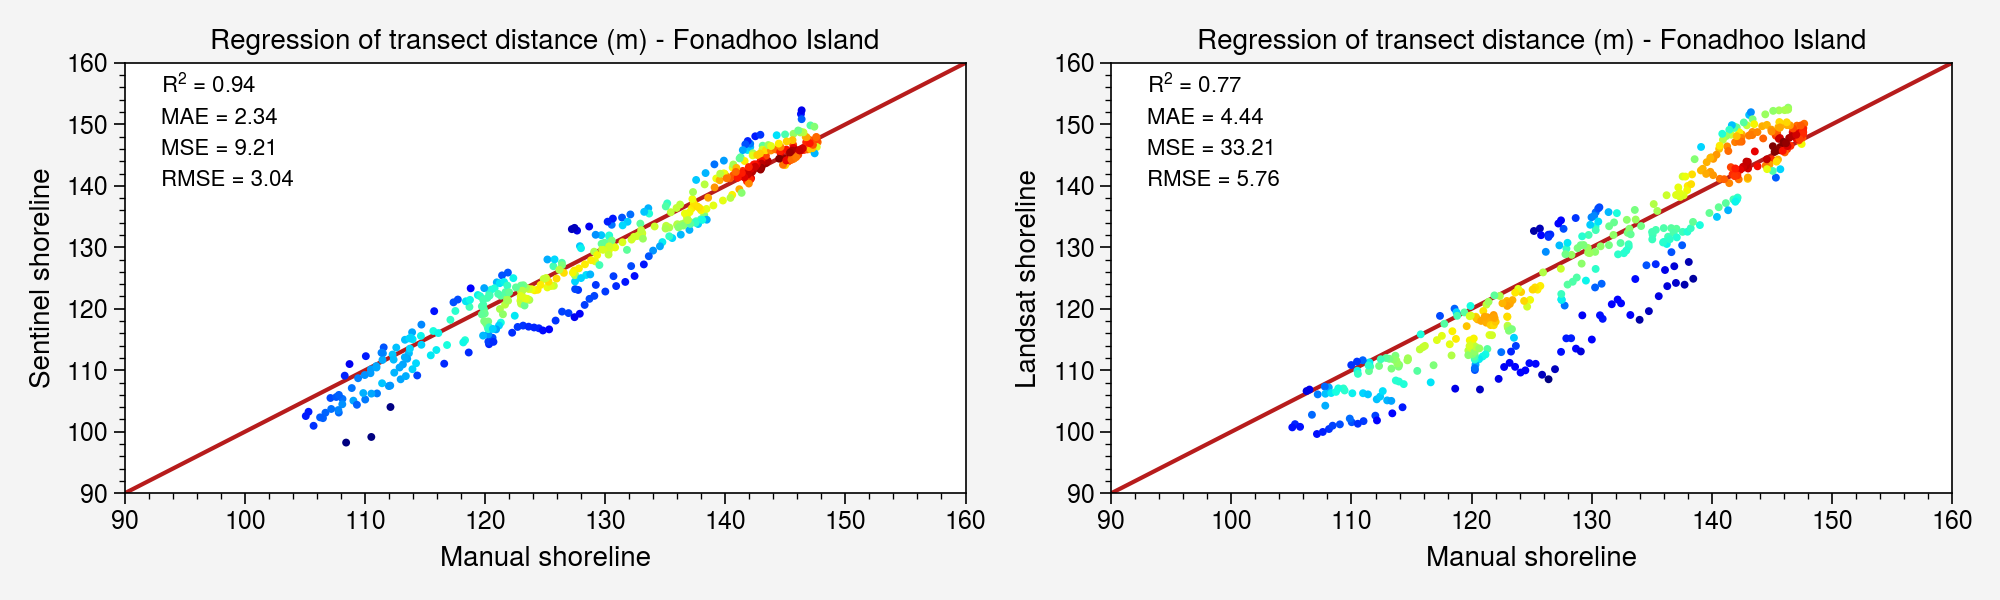

In [8]:
# Plotting regression
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))


percs = np.linspace(0,100,21)
qn_a = np.percentile(x, percs)
qn_b = np.percentile(x, percs)

# Calculate the point density
ax1_xy = np.vstack([x,y])
ax1_density = gaussian_kde(ax1_xy)(ax1_xy)
ax1.scatter(x,y, c=ax1_density, s=5, cmap=plt.cm.jet, marker="o",zorder=3)
line_11 = np.linspace(np.min((qn_a.min(),qn_b.min()))-40, np.max((qn_a.max(),qn_b.max()))+40)
ax1.plot(line_11,line_11, color="#B71C1C", ls="-", lw=1.5)
ax1.set_xlim(90, 160)
ax1.set_ylim(90, 160)
ax1.set_title('Regression of transect distance (m) - Fonadhoo Island', fontsize=10)
ax1.set_ylabel('Sentinel shoreline', fontsize=10)
ax1.set_xlabel('Manual shoreline', fontsize=10)
ax1.grid(False)

ax1.text(93, 155, '$R^2$ = %.2f' % r2_score(x, y), dict(size=8))
ax1.text(93, 150, 'MAE = %.2f' % mean_absolute_error(x, y), dict(size=8))
ax1.text(93, 145, 'MSE = %.2f' % mean_squared_error(x, y, squared=True), dict(size=8))
ax1.text(93, 140, 'RMSE = %.2f' % mean_squared_error(x, y, squared=False), dict(size=8))

# Calculate the point density
ax2_xy = np.vstack([x,z])
ax2_density = gaussian_kde(ax2_xy)(ax2_xy)
ax2.scatter(x,z, c=ax2_density, s=5, cmap=plt.cm.jet, marker="o",zorder=3)
line_11 = np.linspace(np.min((qn_a.min(),qn_b.min()))-40, np.max((qn_a.max(),qn_b.max()))+40)
ax2.plot(line_11,line_11, color="#B71C1C", ls="-", lw=1.5)
ax2.set_xlim(90, 160)
ax2.set_ylim(90, 160)
ax2.set_title('Regression of transect distance (m) - Fonadhoo Island', fontsize=10)
ax2.set_ylabel('Landsat shoreline', fontsize=10)
ax2.set_xlabel('Manual shoreline', fontsize=10)
ax2.grid(False)
ax2.text(93, 155, '$R^2$ = %.2f' % r2_score(x, z), dict(size=8))
ax2.text(93, 150, 'MAE = %.2f' % mean_absolute_error(x, z), dict(size=8))
ax2.text(93, 145, 'MSE = %.2f' % mean_squared_error(x, z, squared=True), dict(size=8))
ax2.text(93, 140, 'RMSE = %.2f' % mean_squared_error(x, z, squared=False), dict(size=8))

plt.tight_layout()
plt.savefig('output/graph/regression_plot.png', dpi=300)
plt.show()

### Calculate difference between manual shoreline and auto-extracted shoreline

In [9]:
# Calculate the transect difference
diff_sentinel = y - x
diff_landsat = z - x

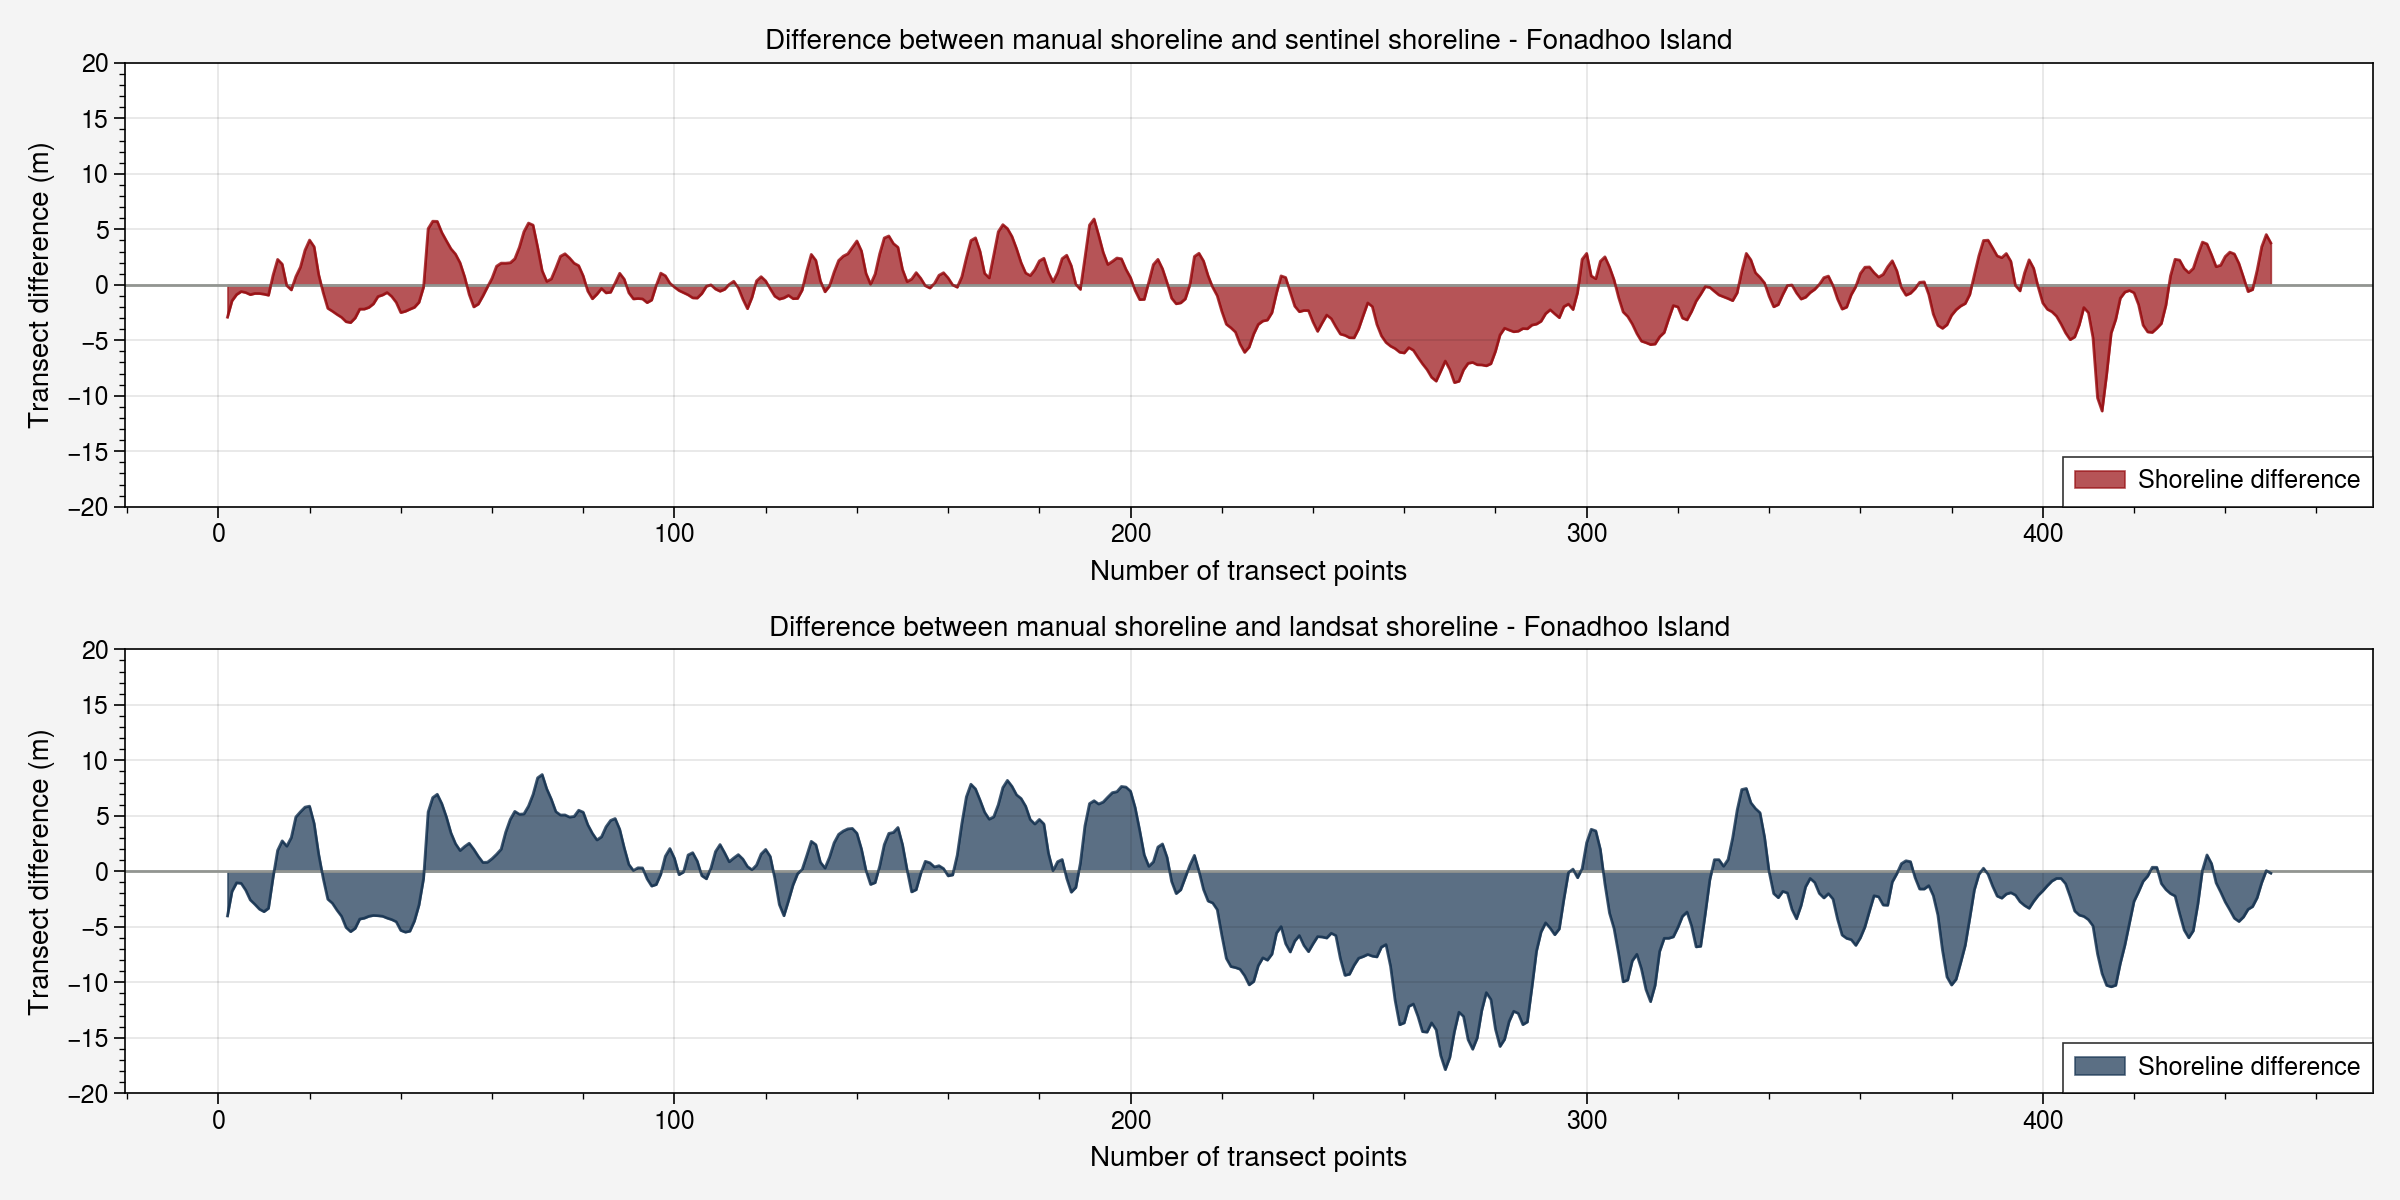

In [10]:
# Plotting regression
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6))


ax1.axhline(y = 0, color = 'grey' , lw=1, alpha=1, linestyle = '-')
ax1.plot(diff_sentinel, color="#970C10", ls='-',lw=1, alpha=0.8, zorder=3)
ax1.fill_between(x.index, diff_sentinel, color="#970C10", alpha=0.7, label='Shoreline difference')
ax1.set_ylim(-20, 20)
ax1.set_title('Difference between manual shoreline and sentinel shoreline - Fonadhoo Island', fontsize=10)
ax1.set_ylabel('Transect difference (m)', fontsize=10)
ax1.set_xlabel('Number of transect points', fontsize=10)
ax1.legend(loc='lower right')

ax2.axhline(y = 0, color = 'grey' , lw=1, alpha=1, linestyle = '-')
ax2.plot(diff_landsat, color="#153250", ls='-',lw=1, alpha=0.8, zorder=4)
ax2.fill_between(x.index, diff_landsat, color="#153250", alpha=0.7, label='Shoreline difference')
ax2.set_ylim(-20, 20)
ax2.set_title('Difference between manual shoreline and landsat shoreline - Fonadhoo Island', fontsize=10)
ax2.set_ylabel('Transect difference (m)', fontsize=10)
ax2.set_xlabel('Number of transect points', fontsize=10)
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('output/graph/3_shoreline_difference.png', dpi=300)
plt.show()

### New Plot Style

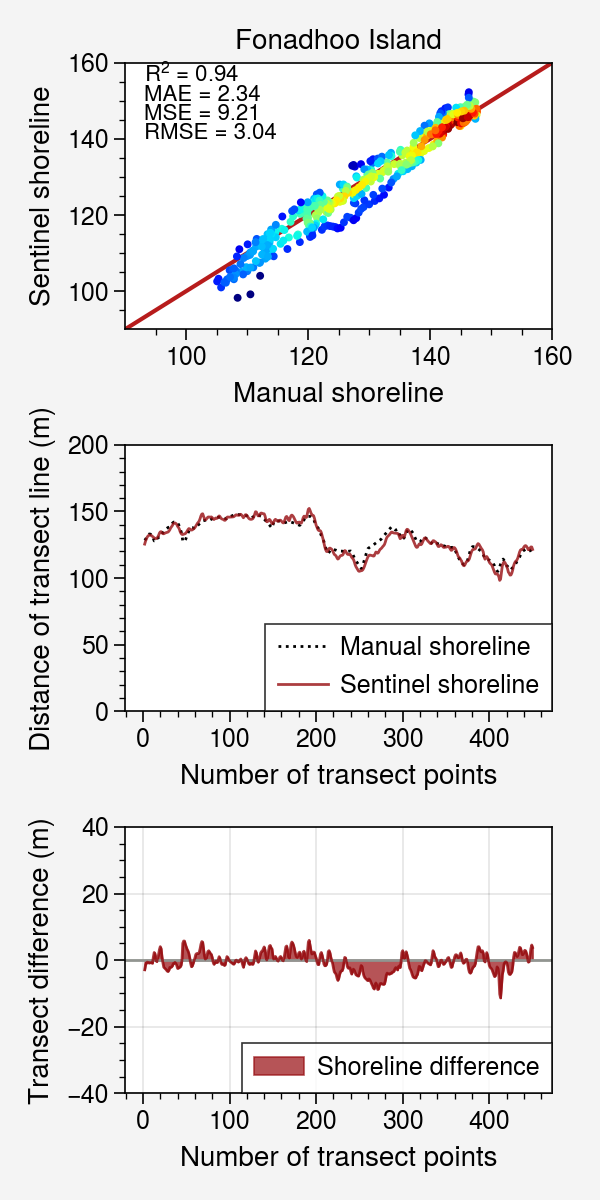

In [11]:
if not os.path.exists('output/graph'):
  os.makedirs('output/graph')

# Plotting regression
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(3,6))

percs = np.linspace(0,100,21)
qn_a = np.percentile(x, percs)
qn_b = np.percentile(x, percs)

# Calculate the point density
ax1_xy = np.vstack([x,y])
ax1_density = gaussian_kde(ax1_xy)(ax1_xy)
ax1.scatter(x,y, c=ax1_density, s=5, cmap=plt.cm.jet, marker="o",zorder=3)
line_11 = np.linspace(np.min((qn_a.min(),qn_b.min()))-40, np.max((qn_a.max(),qn_b.max()))+40)
ax1.plot(line_11,line_11, color="#B71C1C", ls="-", lw=1.5)
ax1.set_xlim(90, 160)
ax1.set_ylim(90, 160)
ax1.set_title('Fonadhoo Island', fontsize=10)
ax1.set_ylabel('Sentinel shoreline', fontsize=10)
ax1.set_xlabel('Manual shoreline', fontsize=10)
ax1.grid(False)

ax1.text(93, 155, '$R^2$ = %.2f' % r2_score(x, y), dict(size=8))
ax1.text(93, 150, 'MAE = %.2f' % mean_absolute_error(x, y), dict(size=8))
ax1.text(93, 145, 'MSE = %.2f' % mean_squared_error(x, y, squared=True), dict(size=8))
ax1.text(93, 140, 'RMSE = %.2f' % mean_squared_error(x, y, squared=False), dict(size=8))


ax2.plot(x, color="black", ls=':', lw=1, alpha=1, label='Manual shoreline')
ax2.plot(y, color="#970C10", ls='-',lw=1, alpha=0.8, label='Sentinel shoreline')
ax2.set_ylim(0, 200)
# ax2.set_title('sentinel ine - Fonadhoo Island', fontsize=10)
ax2.set_ylabel('Distance of transect line (m)', fontsize=10)
ax2.set_xlabel('Number of transect points', fontsize=10)
ax2.legend(loc='lower right')
ax2.grid(False)

# Calculate the transect difference
diff_sentinel = y - x
diff_landsat = z - x

ax3.axhline(y = 0, color = 'grey' , lw=1, alpha=1, linestyle = '-')
ax3.plot(diff_sentinel, color="#970C10", ls='-',lw=1, alpha=0.8, zorder=3)
ax3.fill_between(x.index, diff_sentinel, color="#970C10", alpha=0.7, label='Shoreline difference')
ax3.set_ylim(-40, 40)
# ax3.set_title('Difference between manual shoreline and sentinel shoreline - Fonadhoo Island', fontsize=10)
ax3.set_ylabel('Transect difference (m)', fontsize=10)
ax3.set_xlabel('Number of transect points', fontsize=10)
ax3.legend(loc='lower right')


plt.tight_layout()
plt.savefig('output/graph/3_comparison_stacked.png', dpi=300)
plt.show()

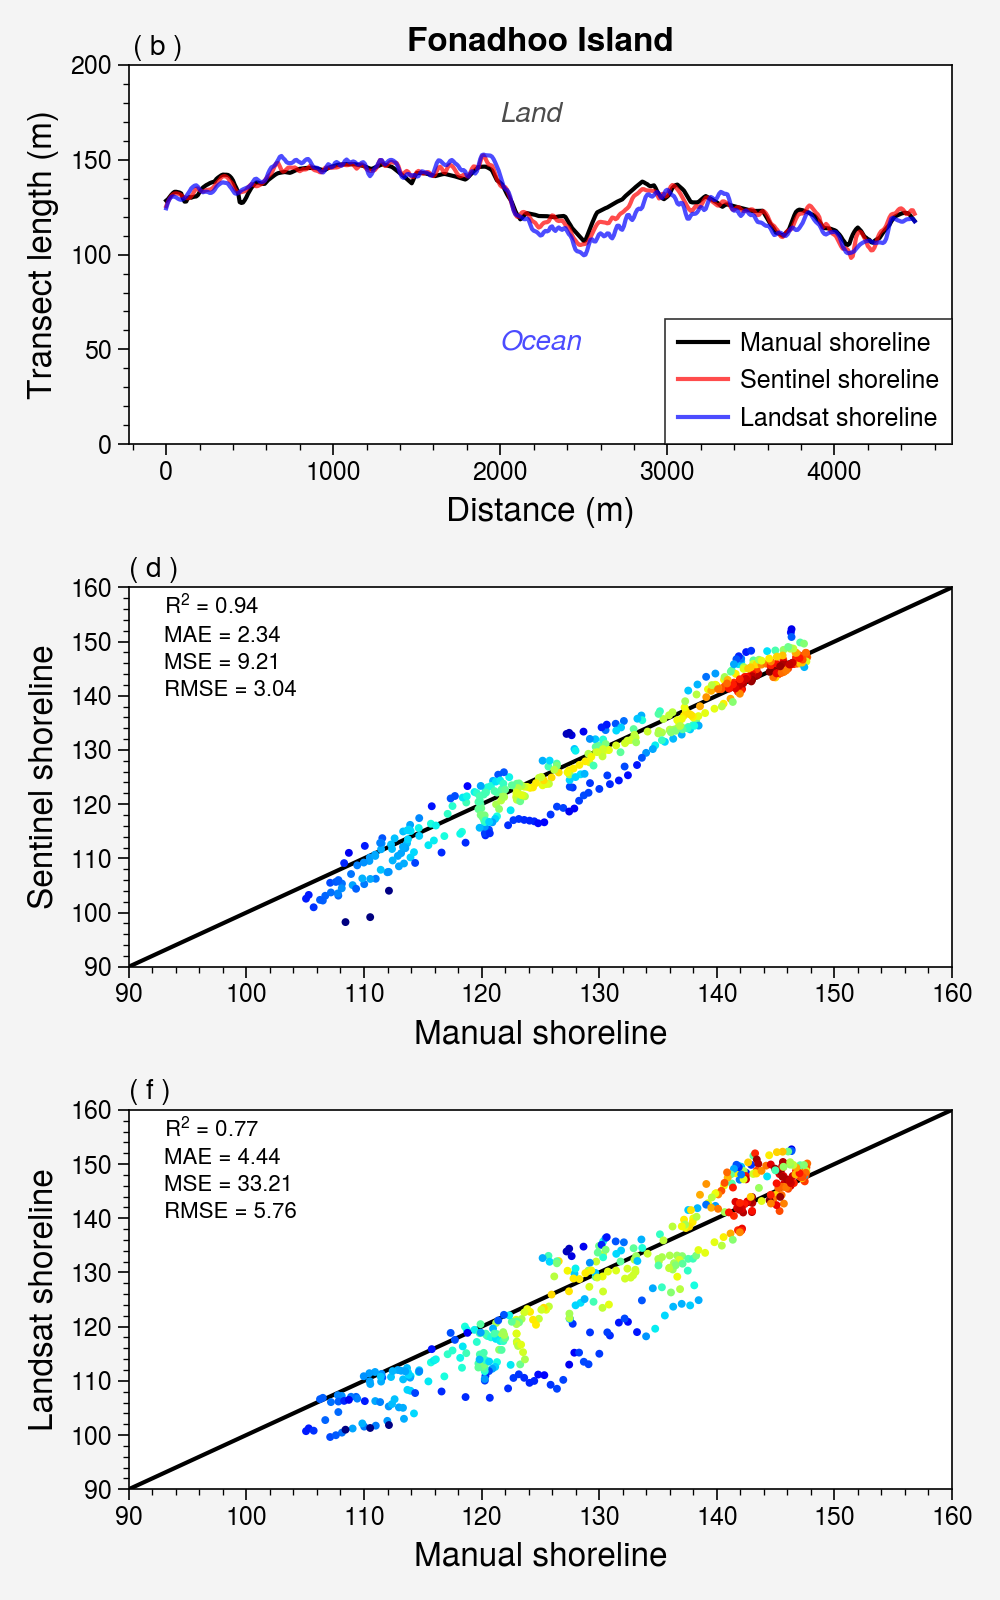

In [12]:
if not os.path.exists('output/graph'):
  os.makedirs('output/graph')

# Plotting regression
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,8))

dist = list((np.array((range(0, len(x))))*10))
ax1.plot(dist, x, color="black", ls='-', lw=1.5, alpha=1, label='Manual shoreline')
ax1.plot(dist, y, color="red", ls='-',lw=1.5, alpha=0.7, label='Sentinel shoreline')
ax1.plot(dist, z, color="blue", ls='-',lw=1.5, alpha=0.7, label='Landsat shoreline')
ax1.set_ylim(0, 200)
ax1.set_title('Fonadhoo Island', fontsize=12, fontweight='bold')
ax1.set_ylabel('Transect length (m)', fontsize=12)
ax1.set_xlabel('Distance (m)', fontsize=12)
ax1.text(-200, 205, '( b )', fontsize=10)
ax1.text(2000, 170, 'Land', fontsize=10, color='black', alpha=0.7, style='italic')
ax1.text(2000, 50, 'Ocean', fontsize=10, color='blue', alpha=0.7, style='italic')
ax1.legend(loc='lower right')
ax1.grid(False)

percs = np.linspace(0,100,21)
qn_a = np.percentile(x, percs)
qn_b = np.percentile(x, percs)

# Calculate the point density
ax2_xy = np.vstack([x,y])
ax2_density = gaussian_kde(ax2_xy)(ax2_xy)
ax2.scatter(x,y, c=ax1_density, s=5, cmap=plt.cm.jet, marker="o",zorder=3)
line_11 = np.linspace(np.min((qn_a.min(),qn_b.min()))-40, np.max((qn_a.max(),qn_b.max()))+40)
ax2.plot(line_11,line_11, color="black", ls="-", lw=1.5)
ax2.set_xlim(90, 160)
ax2.set_ylim(90, 160)
ax2.set_ylabel('Sentinel shoreline', fontsize=12)
ax2.set_xlabel('Manual shoreline', fontsize=12)
ax2.grid(False)
ax2.text(90, 162, '( d )', fontsize=10)
ax2.text(93, 155, '$R^2$ = %.2f' % r2_score(x, y), dict(size=8))
ax2.text(93, 150, 'MAE = %.2f' % mean_absolute_error(x, y), dict(size=8))
ax2.text(93, 145, 'MSE = %.2f' % mean_squared_error(x, y, squared=True), dict(size=8))
ax2.text(93, 140, 'RMSE = %.2f' % mean_squared_error(x, y, squared=False), dict(size=8))


# Calculate the point density
ax3_xy = np.vstack([x,z])
ax3_density = gaussian_kde(ax3_xy)(ax3_xy)
ax3.scatter(x,z, c=ax2_density, s=5, cmap=plt.cm.jet, marker="o",zorder=3)
line_11 = np.linspace(np.min((qn_a.min(),qn_b.min()))-40, np.max((qn_a.max(),qn_b.max()))+40)
ax3.plot(line_11,line_11, color="black", ls="-", lw=1.5)
ax3.set_xlim(90, 160)
ax3.set_ylim(90, 160)
ax3.set_ylabel('Landsat shoreline', fontsize=12)
ax3.set_xlabel('Manual shoreline', fontsize=12)
ax3.grid(False)
ax3.text(90, 162, '( f )', fontsize=10)
ax3.text(93, 155, '$R^2$ = %.2f' % r2_score(x, z), dict(size=8))
ax3.text(93, 150, 'MAE = %.2f' % mean_absolute_error(x, z), dict(size=8))
ax3.text(93, 145, 'MSE = %.2f' % mean_squared_error(x, z, squared=True), dict(size=8))
ax3.text(93, 140, 'RMSE = %.2f' % mean_squared_error(x, z, squared=False), dict(size=8))



plt.tight_layout()
plt.savefig('output/paper_graph/3_comparison_stacked.png', dpi=300)
plt.show()